In [2]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import xbout
import pandas as pd
import numpy as np

# file_dir = os.path.dirname(__file__)

from analysis import *

# from analysis.py import *
# from clean.py import *
# from .analysis import *

%load_ext autoreload
%autoreload 2

In [2]:
# casepath = r"/ssd_scratch/cases/htest/hrac-c5-10-fixbc"
casepath = r"/ssd_scratch/cases/htest/c"
d = BoutData(casepath, yguards = True, info = False, strict = True, 
xind = 0, zind = 0, tind = -1, DataFileCaching=False)["outputs"]

In [ ]:
fig, ax = plt.subplots()

 'density_source_shape_d+',
 'density_source_multiplier_d+',

Complete.


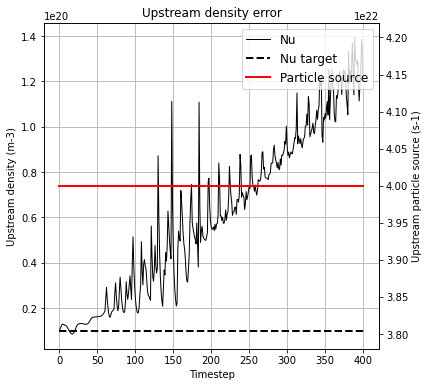

In [ ]:
self.plot_density_controller()

>>> System mass balance
- Total in ---------------
- Input source = 0.000E+00 [s-1]
- Ionisation source = 4.757E+24 [s-1]
- Intended recycling source = 4.757E+24 [s-1]
- Total = 4.757E+24 [s-1]

- Total out ---------------
- Sheath ion flux = 6.937E+24 [s-1]
- Sheath neutral flux = 0.000E+00 [s-1]
- Recombination source = 0.000E+00 [s-1]
- Total = 6.937E+24 [s-1]

- Difference:
---> -2.180E+24 [s-1] (-45.821%)


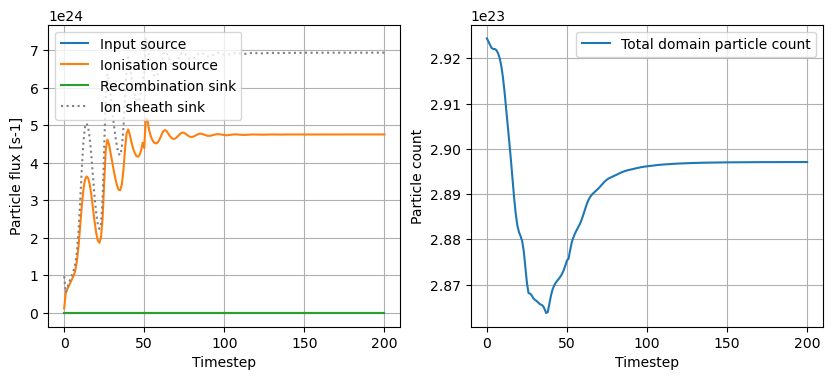

In [5]:
self = Case(r"/ssd_scratch/cases/mbtest/t3-nopicontr")
self.mass_balance_hermes()

>>> System mass balance
- Total in ---------------
- Input source = 0.000E+00 [s-1]
- Ionisation source = 4.758E+24 [s-1]
- Intended recycling source = 4.758E+24 [s-1]
- Total = 4.758E+24 [s-1]

- Total out ---------------
- Sheath ion flux = 6.937E+24 [s-1]
- Sheath neutral flux = 0.000E+00 [s-1]
- Recombination source = -5.768E+20 [s-1]
- Total = 6.938E+24 [s-1]

- Difference:
---> -2.180E+24 [s-1] (-45.815%)


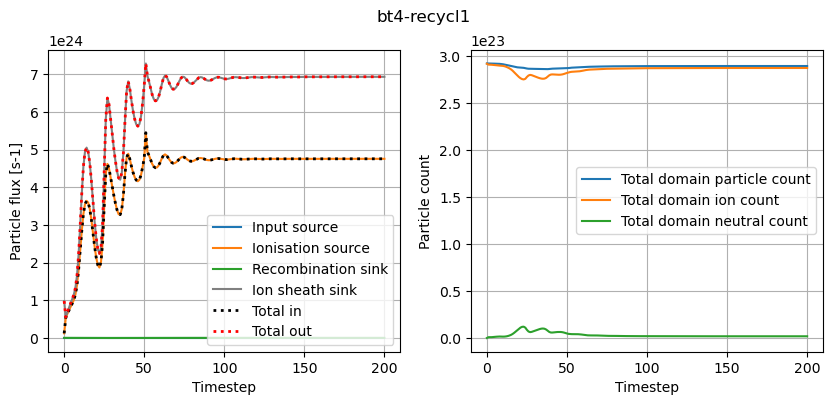

In [7]:
# self = Case(r"/ssd_scratch/cases/mbtest/t3-nopicontr")
# self = Case(r"/ssd_scratch/cases/mbtest/t4-nocx")
# self = Case(r"/ssd_scratch/cases/mbtest/bt1-strip")
# self = Case(r"/ssd_scratch/cases/mbtest/bt2-atomics")
# self = Case(r"/ssd_scratch/cases/mbtest/bt3-recycl0.5")
self = Case(r"/ssd_scratch/cases/mbtest/bt4-recycl1")
# self = Case(r"/ssd_scratch/cases/mbtest/bt4-recycl0.99")

"""
Perform a total (system, so ions and neutrals) mass balance 
for Hermes-3. This is done from scratch and only requires BoutData.
TODO: Figure out if nloss exists in Hermes-3 and include it
"""

# Collect all guard cells, so 2 on each side. The outer ones are not used. 
# Final domain grid centre is therefore index [-3].
# J/sqrt(g_22) = cross-sectional area of cell

boutdata = BoutData(self.casepath, yguards = True, info = False, strict = True, DataFileCaching=False)
d = boutdata["outputs"]
o = boutdata["options"]
tind = -1
J = d["J"].squeeze()
dy = d["dy"].squeeze()
dV = J * dy
g_22 = d["g_22"].squeeze()

mass_p = constants("mass_p")
mass_i = mass_p * 2

# Reconstruct grid position from dy
n = len(dy)
pos = np.zeros(n)
pos[0] = -0.5*dy[1]
pos[1] = 0.5*dy[1]

for i in range(2,n):
    pos[i] = pos[i-1] + 0.5*dy[i-1] + 0.5*dy[i]

def get_boundary_time(x):
    return (x[:,-2] + x[:,-3])/2

def get_boundary(x):
    return (x[-2] + x[-3])/2

# ----- Recycling
recycle_multiplier = float(o["d+"]["recycle_multiplier"])

# ----- Boundary flux
sheath_area = get_boundary(J) / np.sqrt(get_boundary(g_22))
sheath_ion_flux = get_boundary_time(d["NVd+"].squeeze())
sheath_ion_flux *= sheath_area * d["Cs0"] * d["Nnorm"] * mass_p / mass_i

sheath_neutral_flux = get_boundary_time(d["NVd"].squeeze())
sheath_neutral_flux *= sheath_area * d["Cs0"] * d["Nnorm"] * mass_p / mass_i

intended_recycle_flux = sheath_ion_flux * recycle_multiplier

# ----- Density input source
if "Sd+_src" in d.keys():
    input_source = np.trapz(x = pos[2:-2], y = d["Sd+_src"].squeeze()[:,2:-2] * J[2:-2] * d["Cs0"] * d["Nnorm"])
else:
    input_source = np.zeros_like(sheath_ion_flux)

# ----- Ionisation source
if "Sd+_iz" in d.keys():
    iz_source = np.trapz(x = pos[2:-2], y = d["Sd+_iz"].squeeze()[:,2:-2] * J[2:-2] * d["Cs0"] * d["Nnorm"])
else:
    iz_source = np.zeros_like(sheath_ion_flux)

# ----- Recombination source
if "Sd+_rec" in d.keys():
    rec_source = np.trapz(x = pos[2:-2], y = d["Sd+_rec"].squeeze()[:,2:-2] * J[2:-2] * d["Cs0"] * d["Nnorm"])
else:
    rec_source = np.zeros_like(sheath_ion_flux)


# ----- Totals
total_ions = np.trapz(x = pos[2:-2], y = d["Nd+"].squeeze()[:,2:-2] * J[2:-2] * d["Nnorm"])
total_neutrals = np.trapz(x = pos[2:-2], y = d["Nd"].squeeze()[:,2:-2] * J[2:-2] * d["Nnorm"])
total_particles = total_ions + total_neutrals

case_ion_source = np.trapz(x = pos[2:-2], y = d["SNd+"].squeeze()[:,2:-2] * J[2:-2] * d["Cs0"]  * d["Nnorm"])

total_in = input_source + iz_source 
total_out = sheath_ion_flux + abs(rec_source)
total_balance = total_in - total_out

neutral_in = rec_source
neutral_out = iz_source

fig, axes = plt.subplots(1,2, figsize=(10,4), dpi = 100)
fig.suptitle(self.casename)
t = range(len(iz_source))
ax = axes[0]
ax.plot(t, input_source, label = "Input source")
ax.plot(t, iz_source, label = "Ionisation source")
ax.plot(t, rec_source, label = "Recombination sink")
ax.plot(t, sheath_ion_flux, ls = "-", c = "grey", label = "Ion sheath sink")
ax.plot(t, total_in, lw = 2, ls = ":", c = "k", label = "Total in")
ax.plot(t, total_out, lw = 2, ls = ":", c = "r", label = "Total out")
ax.set_ylabel("Particle flux [s-1]")

ax = axes[1]
ax.plot(t, total_particles, label = "Total domain particle count")
ax.plot(t, total_ions, label = "Total domain ion count")
ax.plot(t, total_neutrals, label = "Total domain neutral count")
ax.set_ylabel("Particle count")

for ax in axes:
    ax.grid(which = "both")
    ax.set_xlabel("Timestep")
    ax.legend()

print(">>> System mass balance")
print("- Total in ---------------")
print(f"- Input source = {input_source[-1]:.3E} [s-1]")
print(f"- Ionisation source = {iz_source[-1]:.3E} [s-1]")
print(f"- Intended recycling source = {iz_source[-1]:.3E} [s-1]")
print(f"- Total = {total_in[-1]:.3E} [s-1]")
print("\n- Total out ---------------")
print(f"- Sheath ion flux = {sheath_ion_flux[-1]:.3E} [s-1]")
print(f"- Sheath neutral flux = {sheath_neutral_flux[-1]:.3E} [s-1]")
print(f"- Recombination source = {rec_source[-1]:.3E} [s-1]")
print(f"- Total = {total_out[-1]:.3E} [s-1]")
print(f"\n- Difference:")
print(f"---> {total_balance[-1]:.3E} [s-1] ({total_balance[-1]/total_in[-1]:.3%})")


In [ ]:
Case(r"/ssd_scratch/cases/mbtest/bt3-recycl0.5").mass_balance_hermes()

In [10]:
A = Case(r"/ssd_scratch/cases/mbtest/bt3-recycl0.5")
B = Case(r"/ssd_scratch/cases/mbtest/bt4-recycl1")

In [13]:
for key in A.raw_data.keys():
    if key not in B.raw_data.keys():
        print(key)

Sd+_src
Pd+_src
Sd_src
Pd_src
Pe_src
Sd+_iz
Fd+_iz
Ed+_iz
Rd+_ex
Sd+_rec
Fd+_rec
Ed+_rec
Rd+_rec


In [18]:
B.options.keys()

['mesh',
 'hermes',
 'solver',
 'sheath_boundary_simple',
 'neutral_parallel_diffusion',
 'd+',
 'Nd+',
 'Pd+',
 'NVd+',
 'd',
 'Nd',
 'Pd',
 'e',
 'Pe',
 'recycling',
 'reactions',
 'nout',
 'timestep',
 'MXG']

In [7]:
self.raw_data.keys()

['BOUT_VERSION',
 't_array',
 'iteration',
 'zperiod',
 'MXSUB',
 'MYSUB',
 'MZSUB',
 'PE_XIND',
 'PE_YIND',
 'MYPE',
 'MXG',
 'MYG',
 'MZG',
 'nx',
 'ny',
 'nz',
 'MZ',
 'NXPE',
 'NYPE',
 'NZPE',
 'ZMAX',
 'ZMIN',
 'ixseps1',
 'ixseps2',
 'jyseps1_1',
 'jyseps1_2',
 'jyseps2_1',
 'jyseps2_2',
 'ny_inner',
 'dx',
 'dy',
 'dz',
 'g11',
 'g22',
 'g33',
 'g12',
 'g13',
 'g23',
 'g_11',
 'g_22',
 'g_33',
 'g_12',
 'g_13',
 'g_23',
 'J',
 'Bxy',
 'G1',
 'G2',
 'G3',
 'has_fftw',
 'has_gettext',
 'has_lapack',
 'has_netcdf',
 'has_legacy_netcdf',
 'has_petsc',
 'has_pretty_function',
 'has_pvode',
 'has_scorep',
 'has_slepc',
 'has_sundials',
 'use_backtrace',
 'use_color',
 'use_openmp',
 'use_output_debug',
 'use_sigfpe',
 'use_signal',
 'use_track',
 'use_metric_3d',
 'use_msgstack',
 'Tnorm',
 'Nnorm',
 'Bnorm',
 'Cs0',
 'Omega_ci',
 'rho_s0',
 'ddt(Nd+)',
 'SNd+',
 'kappa_par_d+',
 'Td+',
 'ddt(Pd+)',
 'SPd+',
 'Vd+',
 'ddt(NVd+)',
 'SNVd+',
 'ddt(Nd)',
 'SNd',
 'kappa_par_d',
 'Td',
 '

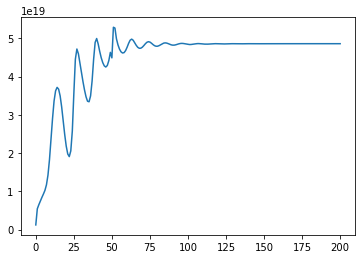

In [30]:
plt.plot(case_ion_source)

In [25]:
sheath_ion_flux[-1]

6.936858592425634e+24

In [11]:
self.raw_data.keys()

['BOUT_VERSION',
 't_array',
 'iteration',
 'zperiod',
 'MXSUB',
 'MYSUB',
 'MZSUB',
 'PE_XIND',
 'PE_YIND',
 'MYPE',
 'MXG',
 'MYG',
 'MZG',
 'nx',
 'ny',
 'nz',
 'MZ',
 'NXPE',
 'NYPE',
 'NZPE',
 'ZMAX',
 'ZMIN',
 'ixseps1',
 'ixseps2',
 'jyseps1_1',
 'jyseps1_2',
 'jyseps2_1',
 'jyseps2_2',
 'ny_inner',
 'dx',
 'dy',
 'dz',
 'g11',
 'g22',
 'g33',
 'g12',
 'g13',
 'g23',
 'g_11',
 'g_22',
 'g_33',
 'g_12',
 'g_13',
 'g_23',
 'J',
 'Bxy',
 'G1',
 'G2',
 'G3',
 'has_fftw',
 'has_gettext',
 'has_lapack',
 'has_netcdf',
 'has_legacy_netcdf',
 'has_petsc',
 'has_pretty_function',
 'has_pvode',
 'has_scorep',
 'has_slepc',
 'has_sundials',
 'use_backtrace',
 'use_color',
 'use_openmp',
 'use_output_debug',
 'use_sigfpe',
 'use_signal',
 'use_track',
 'use_metric_3d',
 'use_msgstack',
 'Tnorm',
 'Nnorm',
 'Bnorm',
 'Cs0',
 'Omega_ci',
 'rho_s0',
 'ddt(Nd+)',
 'SNd+',
 'Sd+_src',
 'kappa_par_d+',
 'Td+',
 'Pd+_src',
 'ddt(Pd+)',
 'SPd+',
 'Vd+',
 'ddt(NVd+)',
 'SNVd+',
 'ddt(Nd)',
 'SNd',
 

In [ ]:

# ----- Totals
total_in = input_source + iz_source
total_out = sheath_ion_flux + abs(rec_source)
total_balance = total_in - total_out

neutral_in = rec_source
neutral_out = iz_source

# print("\System mass balance")
# print("- Total in ---------------")
# print(f"- Input source = {input_source:.3E} [s-1]")
# print(f"- Ionisation source = {iz_source:.3E} [s-1]")
# print(f"- Total = {total_in:.3E} [s-1]")
# print("\n- Total out ---------------")
# print(f"- Sheath ion flux = {sheath_ion_flux:.3E} [s-1]")
# print(f"- Sheath neutral flux = {sheath_neutral_flux:.3E} [s-1]")
# print(f"- Recombination source = {rec_source:.3E} [s-1]")
# print(f"- Total = {total_out:.3E} [s-1]")
# print(f"\n- Difference:")
# print(f"---> {total_balance:.3E} [s-1] ({total_balance/total_in:.3%})")

In [37]:
# %matplotlib widget
%matplotlib widget

Could not collect Te
Could not collect NVi
Could not collect S
Could not collect R
Complete


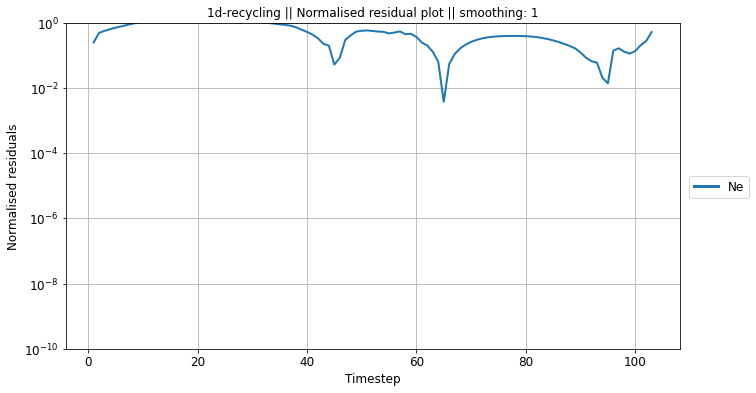

In [4]:
case.plot_residuals()

In [55]:
%matplotlib widget

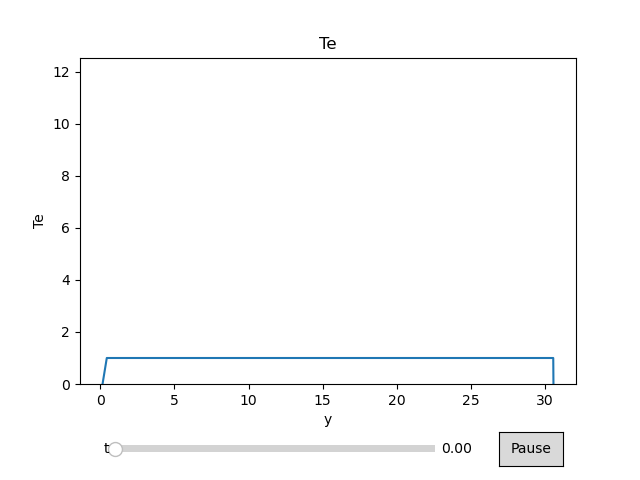

In [58]:

# case = Case(r"/ssd_scratch/cases/htest/hrac-c5-10-fixbc")
anim = self.animate("Te")

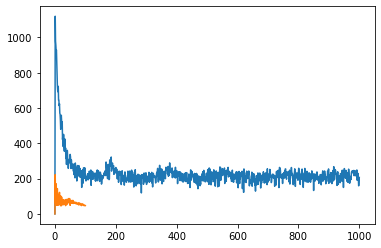

In [21]:
plt.plot(case.rhscalls, label = "Eh1")
plt.plot(A1.rhscalls, label = "A1")

Complete


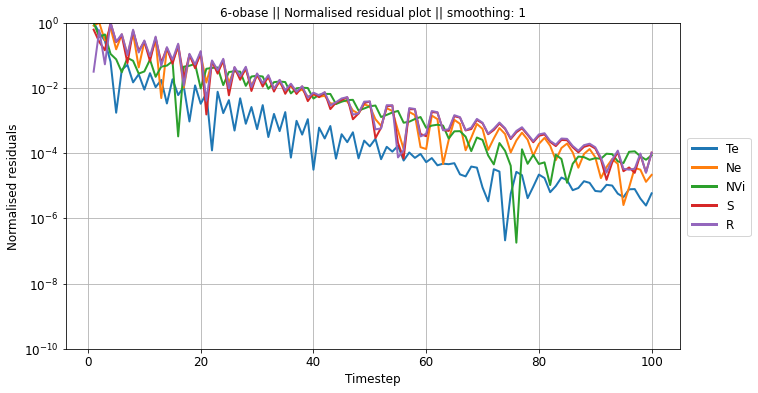

In [34]:
case = Case(os.path.join(studypath, "6-obase"))
case.plot_residuals()

YES
>>> Loading cases: a3-b1i-6 a3-b1io-6 ...Done


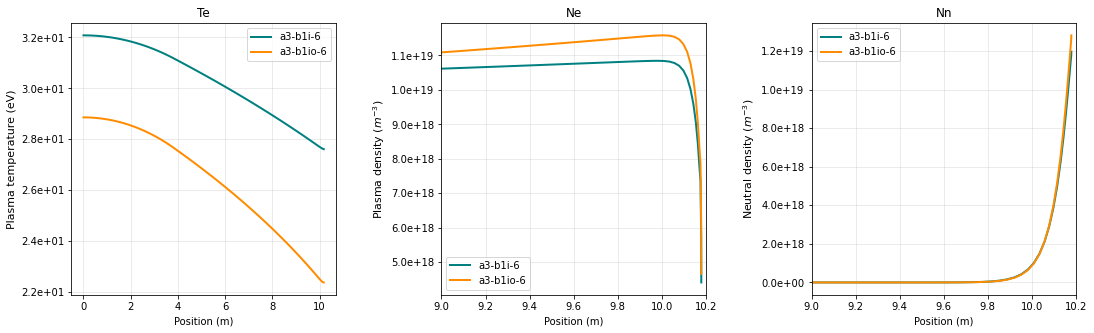

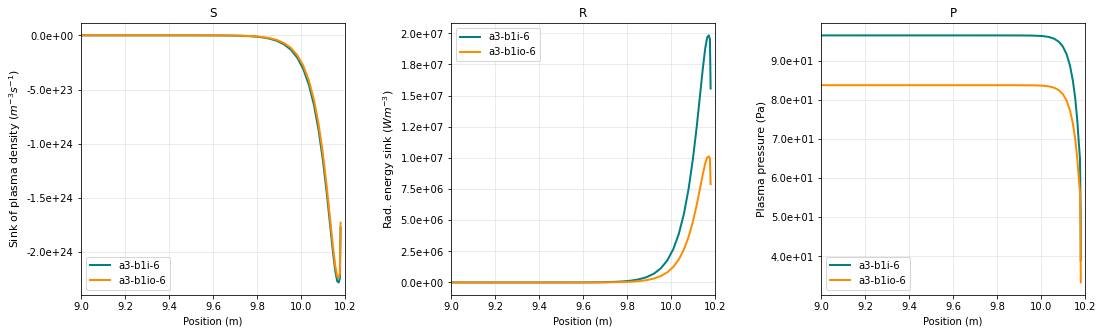

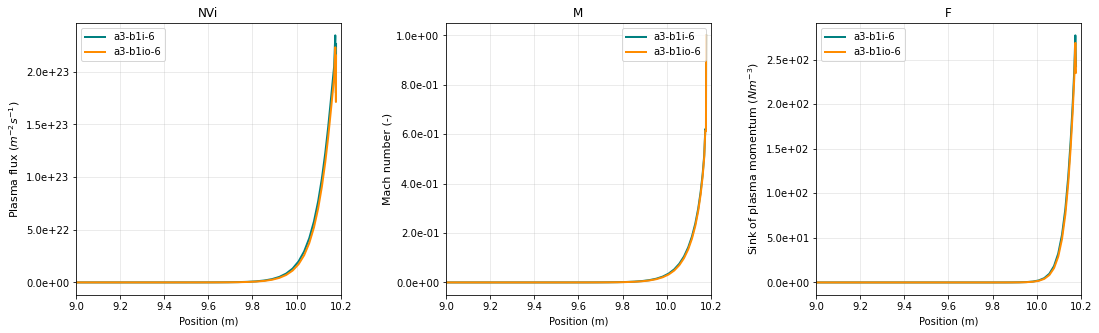

In [13]:


casedeck = CaseDeck(studypath, keys = ["a3-b1i-6", "a3-b1io-6"])
casedeck.plot()

In [48]:
test = casedeck.casepaths_all
test

{'a3-b1i-6': '/ssd_scratch/cases/snb/a3-b1i-6',
 'as3-b1i-6-5': '/ssd_scratch/cases/snb/as3-b1i-6-5',
 '6-s-bm5': '/ssd_scratch/cases/snb/6-s-bm5',
 '6-s-bm4': '/ssd_scratch/cases/snb/6-s-bm4',
 'as3-b1i-6-4': '/ssd_scratch/cases/snb/as3-b1i-6-4',
 'as3-b1i-1': '/ssd_scratch/cases/snb/as3-b1i-1',
 '6-base': '/ssd_scratch/cases/snb/6-base',
 '6-s-bm2': '/ssd_scratch/cases/snb/6-s-bm2',
 'as3-b1i-6-x': '/ssd_scratch/cases/snb/as3-b1i-6-x',
 'as3-b1i-6-2': '/ssd_scratch/cases/snb/as3-b1i-6-2',
 'a3-b1i-1': '/ssd_scratch/cases/snb/a3-b1i-1',
 '6-s-bm1': '/ssd_scratch/cases/snb/6-s-bm1',
 '6-s-bm3': '/ssd_scratch/cases/snb/6-s-bm3',
 'as3-b1i-6': '/ssd_scratch/cases/snb/as3-b1i-6',
 'a3-b1io-6': '/ssd_scratch/cases/snb/a3-b1io-6'}

In [49]:
key = ["a3-b1i-6", "a3-b1io-6"]

for path in test.values():
    if any(x in path for x in key):
        print(path)

/ssd_scratch/cases/snb/a3-b1i-6
/ssd_scratch/cases/snb/a3-b1io-6


/ssd_scratch/scripts/sdtools/analysis.py:289: RuntimeWarning: invalid value encountered in true_divide
  norm[param] = max((res[:norm_range]))


Complete


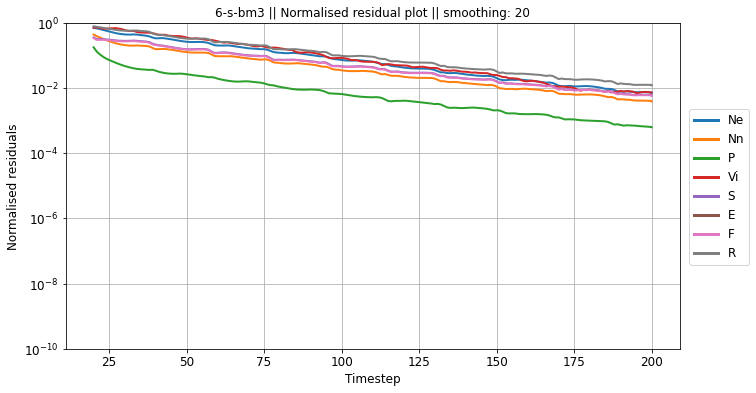

In [39]:
alldeck.cases["6-s-bm3"].plot_residuals()

/ssd_scratch/scripts/sdtools/analysis.py:289: RuntimeWarning: invalid value encountered in true_divide
  norm[param] = max((res[:norm_range]))


Complete


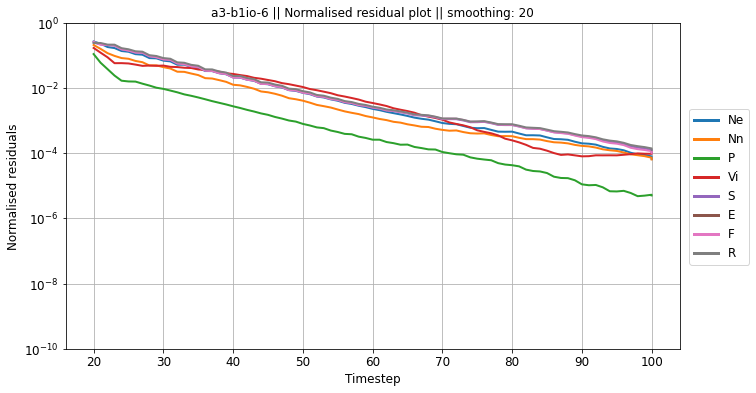

In [30]:
studypath = r"/ssd_scratch/cases/snb/"
case = Case(os.path.join(studypath,"a3-b1io-6"))
case.plot_residuals()

In [35]:
case.options["timestep"]

5000

In [9]:
# casepath = r"C:\Users\Mike\OneDrive\Project\SD1D\studies\g_thesis_snb\as3-b1i-6-x"

case = "6-s-bm3"
# case = "as3-b1i-6-x"
studypath = r"/ssd_scratch/cases/snb/"
casepath = os.path.join(studypath, case)
datapath = os.path.join(casepath, "BOUT.dmp.*.nc")
inputfilepath = os.path.join(casepath, "BOUT.inp")


ds = xbout.open_boutdataset(datapath = datapath, inputfilepath = inputfilepath, 
                    info = False, keep_yboundaries = True)
ds = ds.squeeze(drop = True)

In [3]:
os.get_cwd()

AttributeError: module 'os' has no attribute 'get_cwd'

In [ ]:
deck = 

In [3]:
case = Case()

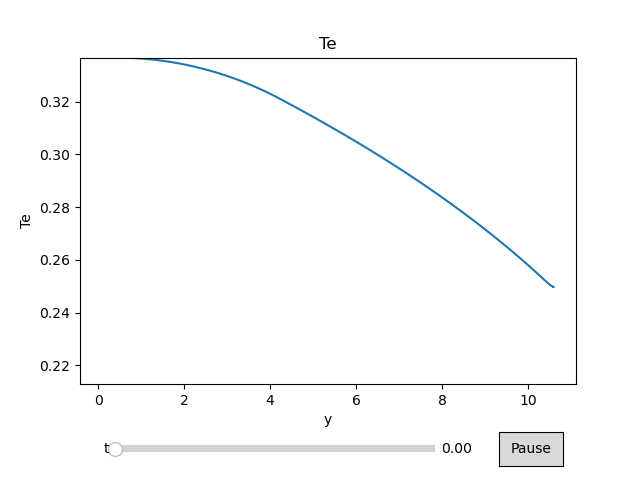

In [10]:
xbout.plotting.animate.animate_line(ds.Te)

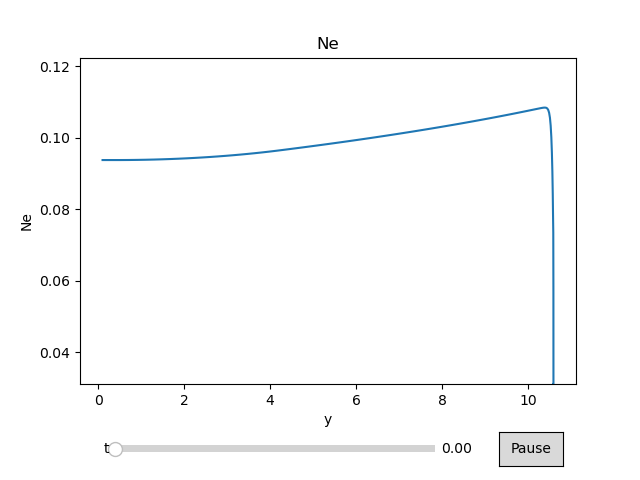

In [10]:
xbout.plotting.animate.animate_line(ds.Ne)

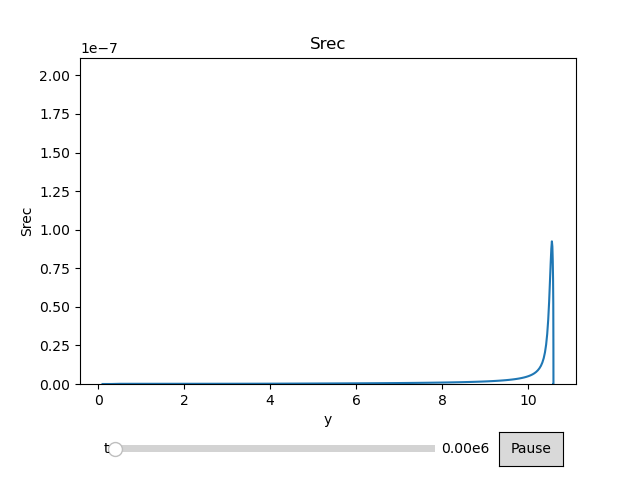

In [20]:
xbout.plotting.animate.animate_line(ds.Srec)